# Homework 2 - Convolutional Neural Nets

In this homework, we will be working with google [colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on google servers using a GPU or TPU. To enable GPU support, make sure to press Runtime -> Change Runtime Type -> GPU.

## Cats vs dogs classification

To learn about and experiment with convolutional neural nets we will be working on a problem of great importance in computer vision - classifying images of cats and dogs.

The problem is so important that there's even an easter egg in colab: go to Tools -> Settings -> Miscellaneous and enable 'Corgi mode' and 'Kitty mode' to get more cats and dogs to classify when you're tired of coding.



### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [1]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2025-10-01 20:59:22--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.207, 142.251.18.207, 192.178.213.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M  29.0MB/s    in 2.3s    

2025-10-01 20:59:25 (29.0 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
! unzip -qo cats_and_dogs_filtered.zip

This dataset contains two directories, `train` and `validation`. Both in turn contain two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats, and another 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a convolutional neural net to classify these images, i.e. given an image from this dataset, tell if it contains a cat or a dog.



In [3]:
! echo 'Training cats examples:' $(find cats_and_dogs_filtered/train/cats -type f | wc -l)
! echo 'Training dogs examples:' $(find cats_and_dogs_filtered/train/dogs -type f | wc -l)
! echo 'Validation cats examples:' $(find cats_and_dogs_filtered/validation/cats -type f | wc -l)
! echo 'Validation dogs examples:' $(find cats_and_dogs_filtered/validation/dogs -type f | wc -l)

Training cats examples: 1000
Training dogs examples: 1000
Validation cats examples: 500
Validation dogs examples: 500


### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch ecosystem, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html).

 In the case of computer vision, the datasets with the folder structure 'label_name/image_file' are very common, and to process those there's already a class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). Torchvision is a Pytorch library with many commonly used tools in computer vision.

 Another thing we need from Torchvision library is transforms ([documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)). In computer vision, we very often want to transform the images in certain ways. The most common is normalization. Others include flipping, changing saturation, hue, contrast, rotation, and blurring.

 Below, we create a training, validation and test sets. We use a few transforms for augmentation on the training set, but we don't use anything but resize and normalization for validation and test.

In [4]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images

# These numbers are mean and std values for channels of natural images.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(),  # convert PIL to Pytorch Tensor
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
validation_dataset, test_dataset = torch.utils.data.random_split(torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms), [500, 500], generator=torch.Generator().manual_seed(42))

Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

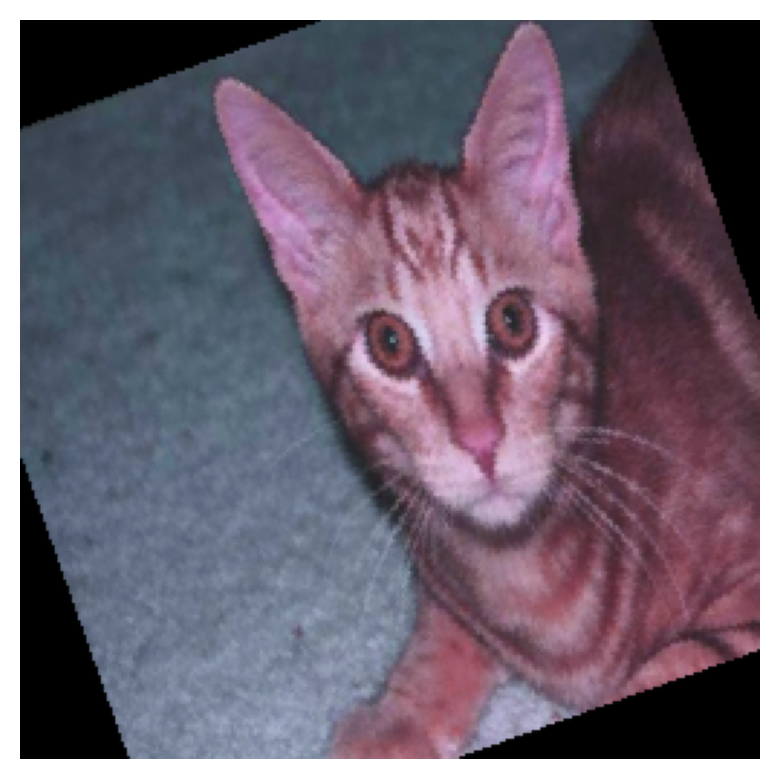

In [5]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
  plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')

show_normalized_image(train_dataset[10][0])

### Creating the model

Now is the time to create a model. All models in Pytorch are subclassing `torch.nn.Module`, and have to implement `__init__` and `forward` methods.

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a convolutional neural network containing the following elements:

* Convolutional layers (at least two)
* Batch Norm
* Non-linearity
* Pooling layers
* A residual connection similar to that of Res-Net
* A fully connected layer

For some examples of how to implement Pytorch models, please refer to our lab notebooks, such as [this one](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb).

In [27]:
from torch import nn
import torch.nn.functional as F

class CNN_Solution(nn.Module):
    def __init__(self):
        super().__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.residual_proj = nn.Conv2d(32, 64, kernel_size=1)  # keep unique name

        # Third block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fourth block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling & dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected (after GAP, features = 256 channels only)
        self.fc = nn.Linear(256, 2)


    def forward(self, x):
        # ---- Block 1 ----
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        # ---- Block 2 with residual ----
        out = self.conv2(x)
        out = self.bn2(out)
        out = F.relu(out)

        # if channels don’t match, use projection
        if x.shape[1] != out.shape[1]:
            res = self.residual_proj(x)
        else:
            res = x

        out = out + res
        out = self.pool(out)

        # ---- Block 3 ----
        out = F.relu(self.bn3(self.conv3(out)))
        out = self.pool(out)

        # ---- Block 4 ----
        out = F.relu(self.bn4(self.conv4(out)))
        out = self.pool(out)
        out = self.dropout(out)

        # ---- Global Average Pooling ----
        out = self.gap(out)
        out = out.view(out.size(0), -1)

        # ---- Fully connected ----
        out = self.fc(out)
        return out



### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [18]:
from tqdm.notebook import tqdm

from tqdm.notebook import tqdm

def get_loss_and_correct(model, batch, criterion, device):
    # forward + loss + correct count
    inputs, targets = batch
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum()
    return loss, correct

def step(loss, optimizer):
    # TODO backward + step
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    optimizer.step()


N_EPOCHS = 30
BATCH_SIZE = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4)
model = CNN_Solution()


# Optimizer & Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008, weight_decay=1e-4)  # L2 regularization
# TODO: Learning rate scheduler to adaptively reduce LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



model.train()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0

    model.train()
    for batch in tqdm(train_dataloader, leave=False):
        loss, correct = get_loss_and_correct(model, batch, criterion, device)
        step(loss, optimizer)
        total_train_loss += loss.item()
        total_train_correct += correct.item()

    model.eval()
    with torch.no_grad():
        for batch in validation_dataloader:
            loss, correct = get_loss_and_correct(model, batch, criterion, device)
            total_validation_loss += loss.item()
            total_validation_correct += correct.item()

    mean_train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct / len(train_dataset)

    mean_validation_loss = total_validation_loss / len(validation_dataset)
    validation_accuracy = total_validation_correct / len(validation_dataset)

    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    # 🔑 Step the scheduler using validation loss
    scheduler.step(mean_validation_loss)

    pbar.set_postfix({
        'train_loss': mean_train_loss,
        'validation_loss': mean_validation_loss,
        'train_accuracy': train_accuracy,
        'validation_accuracy': validation_accuracy,
        'lr': optimizer.param_groups[0]['lr']  # show LR in tqdm bar
    })


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

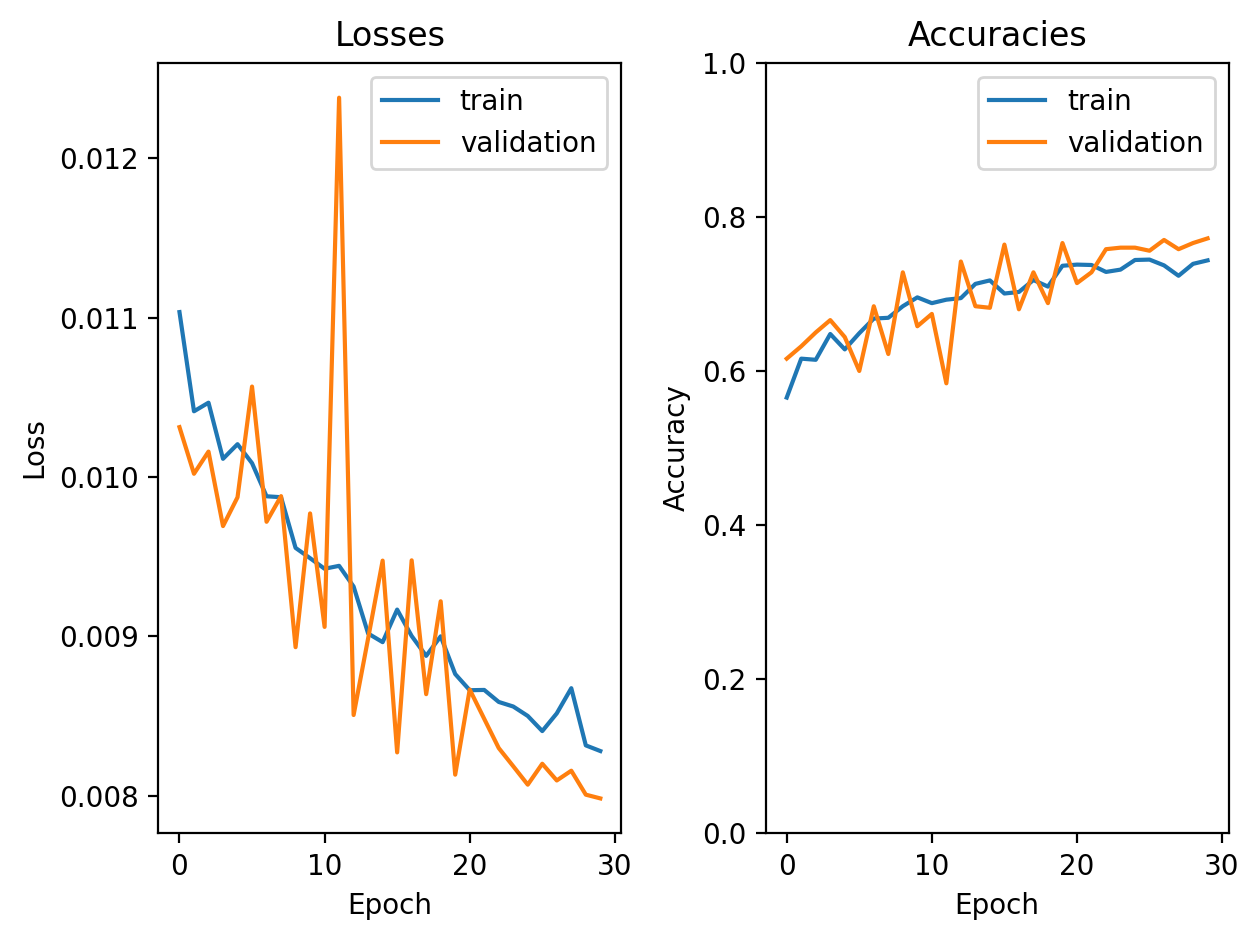

In [19]:
plt.figure(dpi=200)

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()

Now, change your model to achieve at least 75% accuracy on validation set. You can change the model you've implemented, the optimizer, and the augmentations.

Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?

Answer:
Looking at the loss and accuracy plots, the model does not overfit the training set. Training and validation losses both decrease, and validation accuracy is consistently close to (and even slightly higher than) training accuracy. In overfitting, we would expect training accuracy to be much higher while validation accuracy drops, which is not the case here.Instead, the curves suggest the model is still generalizing well, with steady improvements on both datasets

---



### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

In [20]:
# TODO
# 1. Calculate and show the test_dataset accuracy of your model.
# 2. Visualize some correctly and incorrectly classified examples.

✅ Test Accuracy: 0.7220


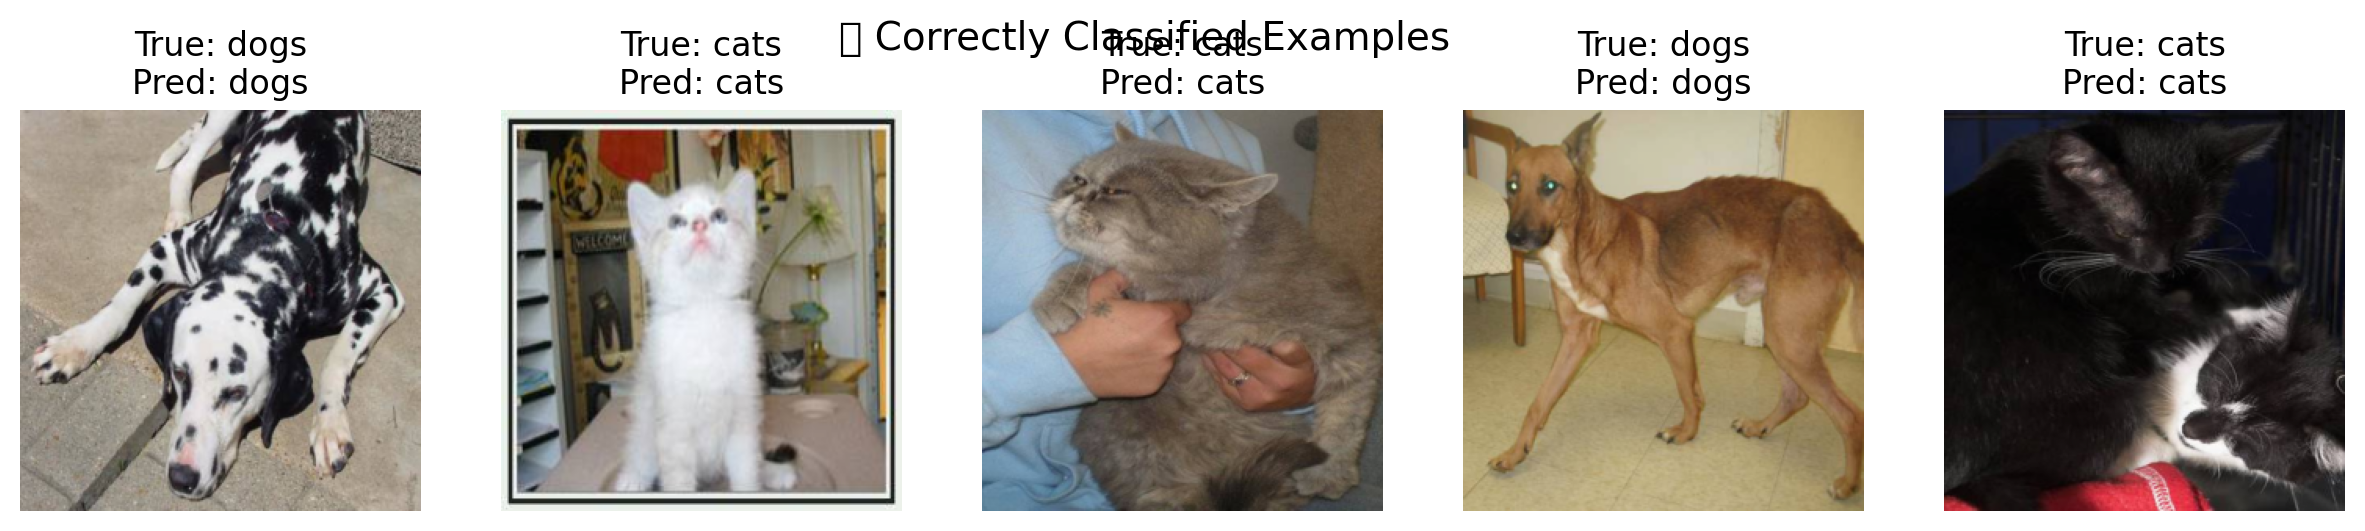

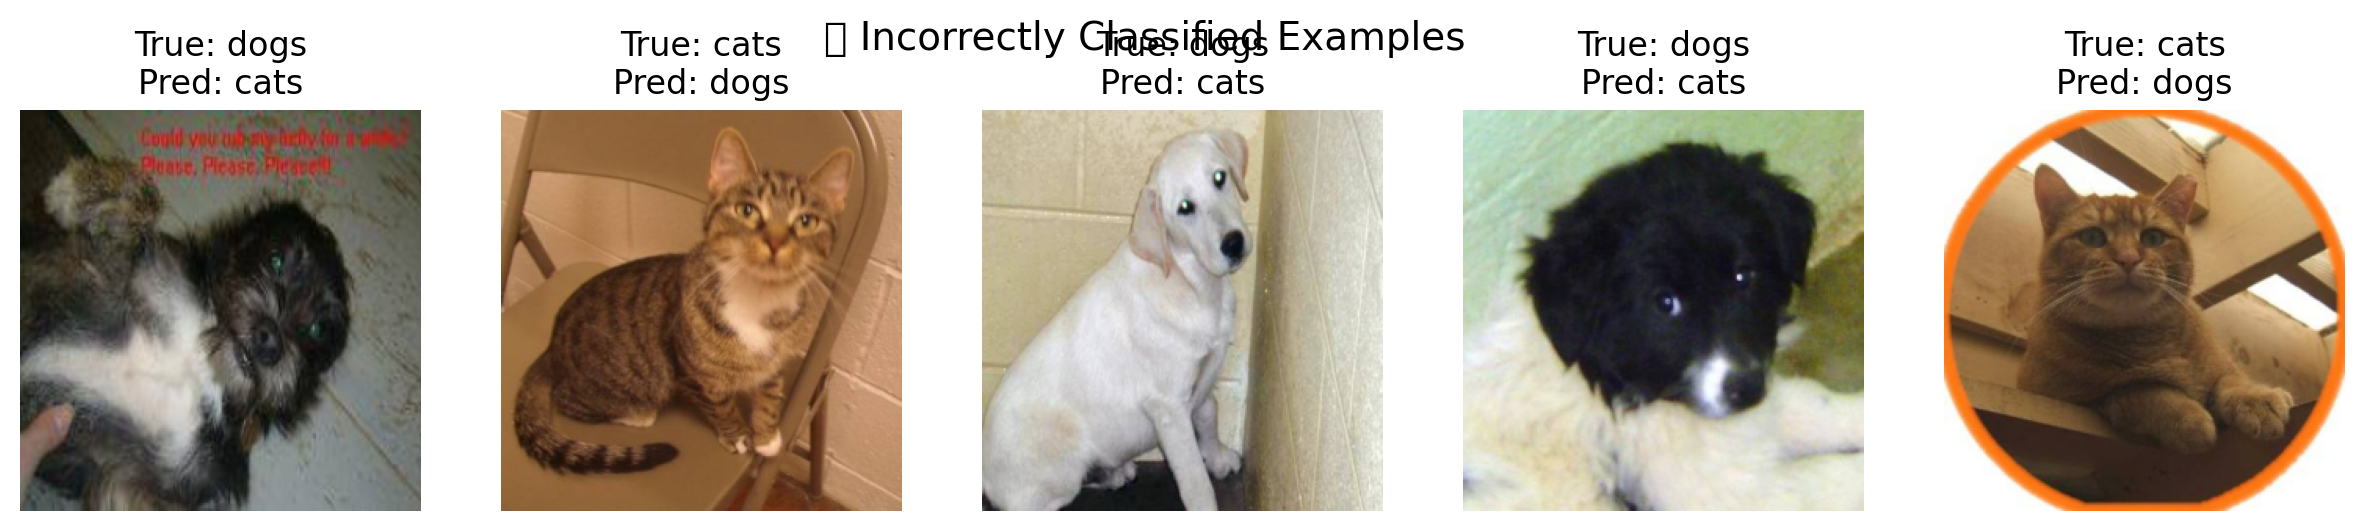

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Put model in eval mode
model.eval()

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

total_correct = 0
total_samples = 0

correct_examples = []
incorrect_examples = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        # Save examples for visualization
        for img, label, pred in zip(images, labels, preds):
            if label == pred and len(correct_examples) < 5:
                correct_examples.append((img.cpu(), label.item(), pred.item()))
            elif label != pred and len(incorrect_examples) < 5:
                incorrect_examples.append((img.cpu(), label.item(), pred.item()))

test_accuracy = total_correct / total_samples
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# -----------------------------
# Visualization
# -----------------------------
classes = train_dataset.classes  # ['cats', 'dogs']

def show_examples(examples, title):
    fig, axes = plt.subplots(1, len(examples), figsize=(15, 3))
    fig.suptitle(title, fontsize=14)
    for ax, (img, label, pred) in zip(axes, examples):
        img = unnormalize(img)  # convert back from normalized
        img = np.clip(img.permute(1, 2, 0).numpy(), 0, 1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"True: {classes[label]}\nPred: {classes[pred]}")

show_examples(correct_examples, "✅ Correctly Classified Examples")
show_examples(incorrect_examples, "❌ Incorrectly Classified Examples")


### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

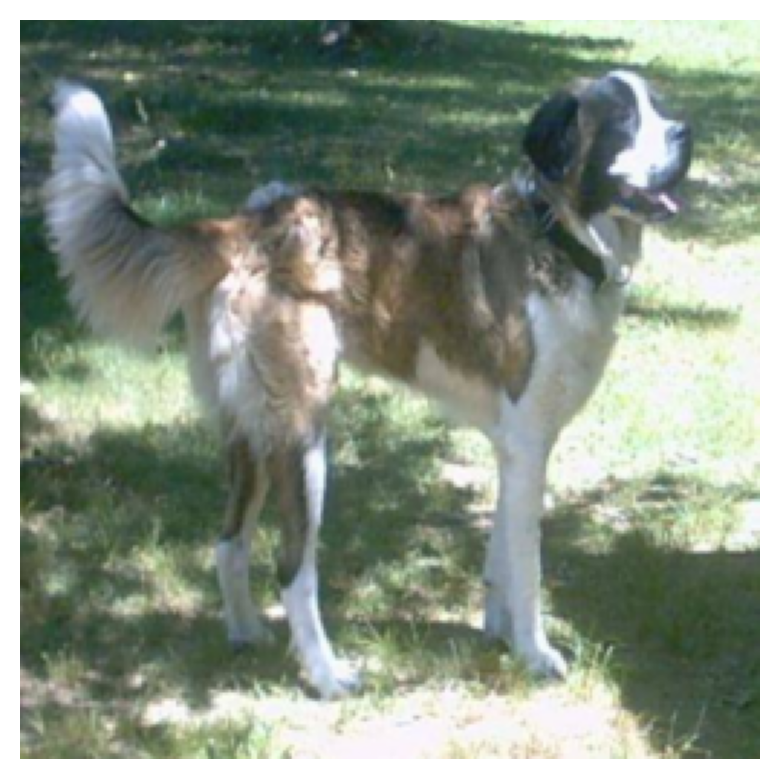

In [22]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to 'clip' our model at different points to get different intermediate representation.
Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:4])
)
intermediate_output = clipped(input)
```



In [23]:
import math

def plot_intermediate_output(result, title):
  """ Plots the intermediate output of shape
      N_FILTERS x H x W
  """
  n_filters = result.shape[1]
  N = int(math.sqrt(n_filters))
  M = (n_filters + N - 1) // N
  assert N * M >= n_filters

  fig, axs = plt.subplots(N, M)
  fig.suptitle(title)

  for i in range(N):
    for j in range(M):
      if i*N + j < n_filters:
        axs[i][j].imshow(result[0, i*N + j].cpu().detach())
        axs[i][j].axis('off')

# TODO:
# pick a few intermediate representations from your network and plot them using
# the provided function.

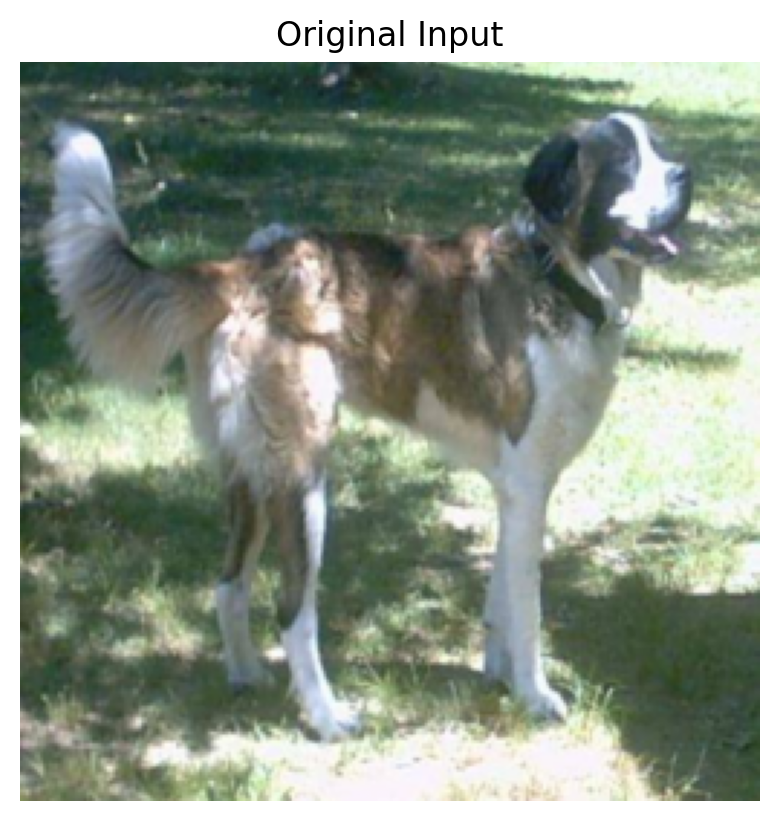

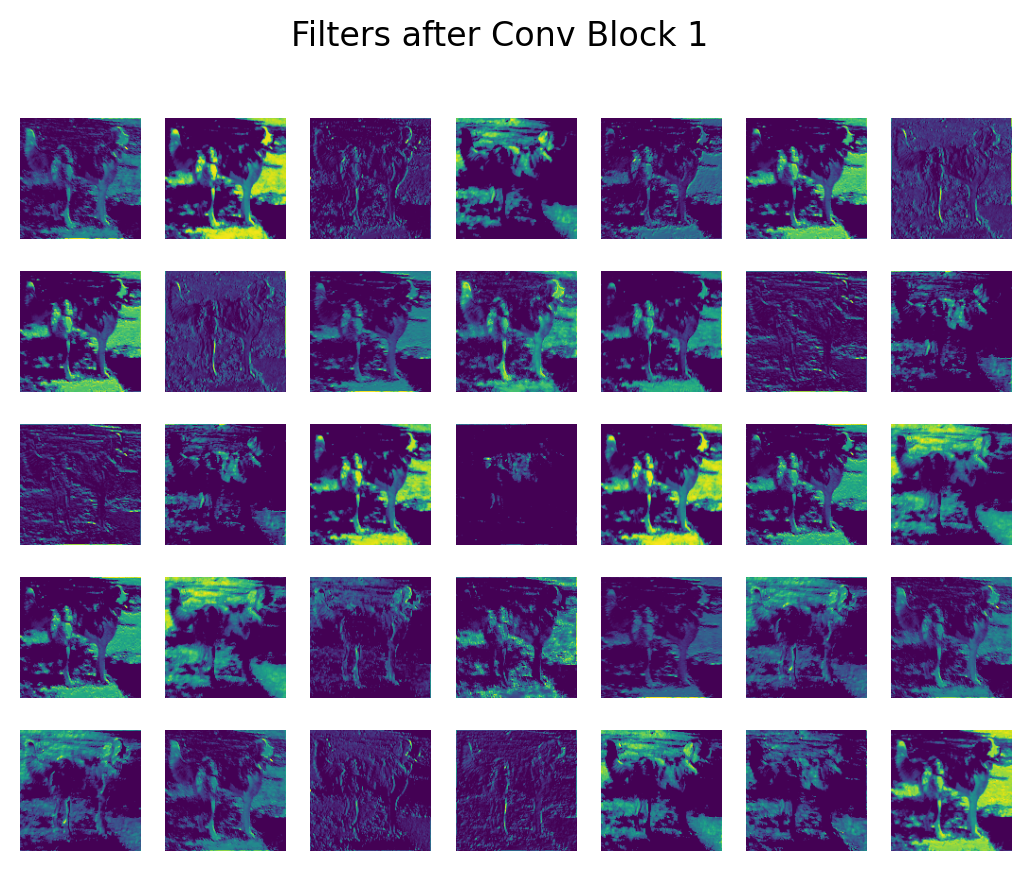

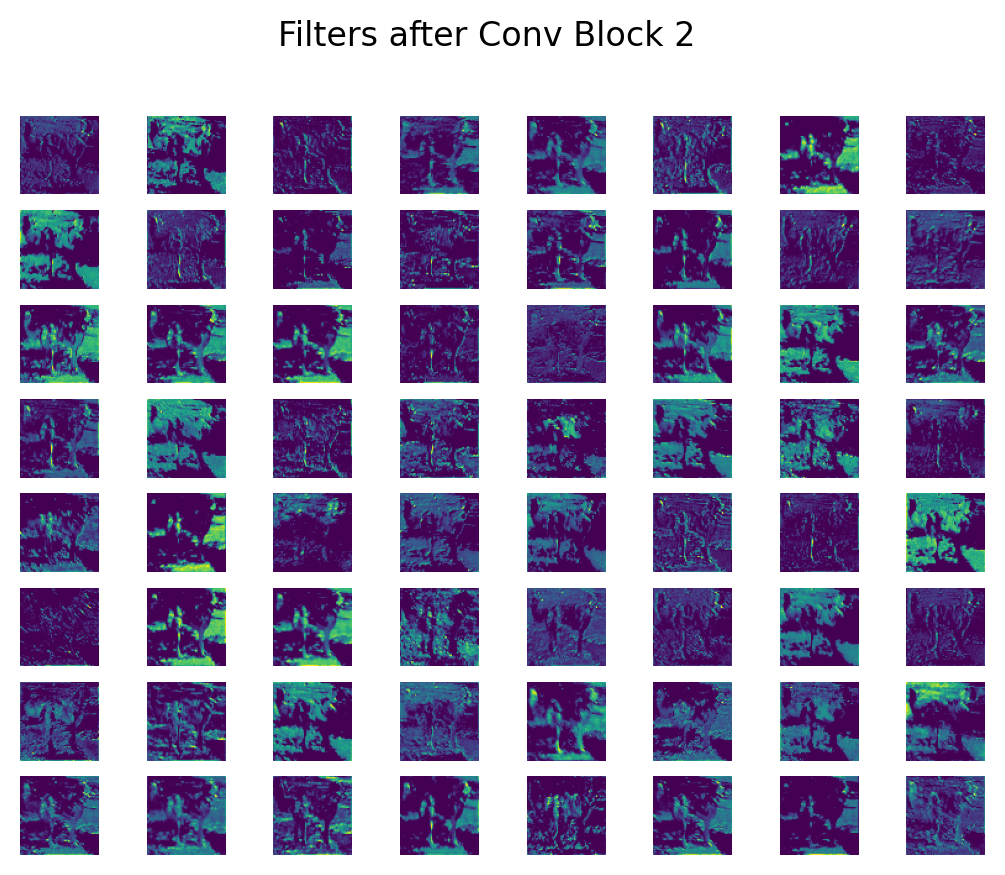

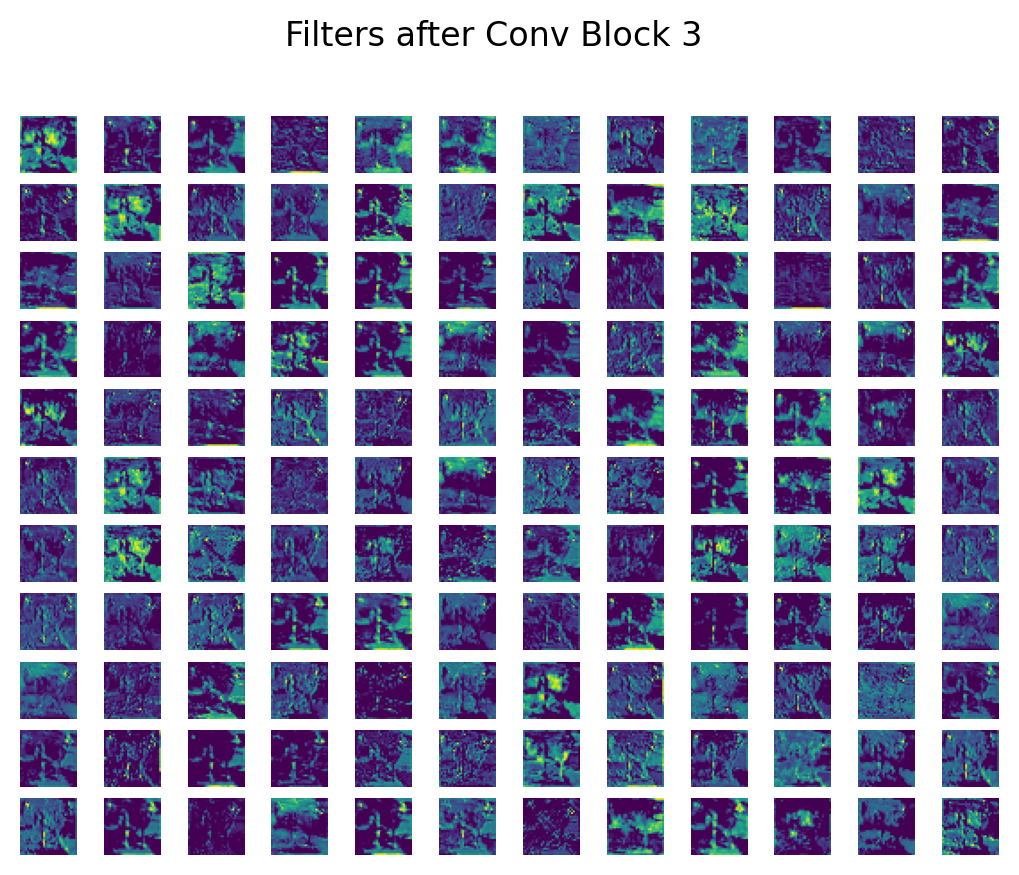

In [29]:
import torch

# Take one image from validation dataset
image = validation_dataset[10][0].unsqueeze(0).to(device)  # add batch dim
show_normalized_image(validation_dataset[10][0], title="Original Input")

# --- Clip the model at different depths ---
# After first conv block
clipped1 = nn.Sequential(
    model.conv1, model.bn1, nn.ReLU(), model.pool
)

# After second conv block (with residual projection)
clipped2 = nn.Sequential(
    model.conv1, model.bn1, nn.ReLU(), model.pool,
    model.conv2, model.bn2, nn.ReLU(), model.pool
)

# After third conv block
clipped3 = nn.Sequential(
    model.conv1, model.bn1, nn.ReLU(), model.pool,
    model.conv2, model.bn2, nn.ReLU(), model.pool,
    model.conv3, model.bn3, nn.ReLU(), model.pool
)

# Make sure modules are on the same device
clipped1, clipped2, clipped3 = clipped1.to(device), clipped2.to(device), clipped3.to(device)

# Get intermediate outputs
with torch.no_grad():
    out1 = clipped1(image)
    out2 = clipped2(image)
    out3 = clipped3(image)

# --- Plot ---
plot_intermediate_output(out1, "Filters after Conv Block 1")
plot_intermediate_output(out2, "Filters after Conv Block 2")
plot_intermediate_output(out3, "Filters after Conv Block 3")


What can you say about those filters? What features are they focusing on?

Answer:
Block 1 filters: Look like edge/texture detectors (horizontal/vertical lines, color blobs).

Block 2 filters: Capture more complex patterns (fur texture, eyes, nose shapes).

Block 3 filters: Highly abstract features — parts of faces, high-level textures